# Introduction to atomman: Dislocation solution and generator

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction<a id='section1'></a>

This Notebook outlines the Dislocation class in atomman that provides methods for generating a number of standard atomistic dislocation configurations.  

- [Section #2](#section2) details how dislocations are defined so that they can be used to construct the atomic systems.
- [Section #3](#section3) introduces the Dislocation class that provides a convenient means of constructing atomic configurations of dislocations.
- [Section #4](#section4) shows how the Dislocation class can be used to generate dislocation monopole configurations.
- [Section #5](#section5) shows how the Dislocation class can be used to generate periodic array of dislocations configurations.
- [Section #6](#section6) shows how the Dislocation class can be used to generate stable dislocation dipole configurations.

In [1]:
# Standard Python libraries
import os
import datetime

# http://www.numpy.org/
import numpy as np

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

# https://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today()) 

atomman version = 1.5.0
Notebook executed on 2024-12-11


## 2. Theory<a id='section2'></a>

The Dislocation class provides methods for generating standard atomic configurations of dislocations that have been used to  study dislocation core structures and the slip behaviors of individual dislocations.  All of the generation methods supported by the Dislocation class follow the same four basic steps

1. The type of dislocation that is to be studied is defined for a particular crystal structure/prototype using crystallographic planes and vectors.
2. A dislocation solution is obtained based on the definition provided and other necessary materials properties.
3. The dislocation solution and atomic positions of the bulk crystal need to be properly aligned with each other.
4. One or more dislocations are inserted into the bulk crystal by displacing atoms according to the dislocation solution.
5. Boundary conditions are applied to accommodate the long range stress and strain fields generated by the dislocations.

Steps 1-3 are core properties of the Dislocation class as they are common across all of the configuration methods, while 4+5 depend on the specific atomic configuration being generated.

### 2.1. Dislocation definition

The Dislocation class allows for different types of dislocations to be defined using crystallographic planes and vectors relative to a given crystal structure.  Using crystallographic planes and vectors is convenient as

- this is how dislocations are typically defined by the materials science community,
- it provides a convenient means of generalizing the methods for any crystal structure, and
- the use of lattice vectors helps ensure that the resulting atomic configurations remain coherent across periodic boundaries.

All of the atomic configurations are based on infinitely long, perfectly straight Volterra dislocations, and thus are fully defined with four parameter terms

- The atomic unit cell system that the other terms are defined relative to,
- $\vec{b}_{[uvw]}$, the crystallographic [uvw] Burgers vector of the dislocation.
- $\vec{n}_{(hkl)}$, the crystallographic (hkl) slip plane that the dislocation is in.  For screw dislocations that can cross-slip, this should be the expected or wanted plane of slip.
- $\vec{\xi}_{[uvw]}$, the crystallographic [uvw] vector for the dislocation line.

The dislocation's character (screw, edge, mixed) is given by the angle between the Burgers vector and the line vector.  Screw dislocations have the line direction parallel to the Burgers vector, and therefore have a character angle of 0$^{\circ}$ or 180$^{\circ}$, while edge dislocations have the two directions perpendicular for a character angle of 90$^{\circ}$.  The allowed values of $\vec{\xi}_{[uvw]}$ are limited to lattice vectors as all of the atomic configurations treat the line direction as periodic.  Note that this limits the dislocation character angles that can be explored.

### 2.2. Dislocation solution

A Volterra dislocation solution is obtained for each dislocation.  The solution itself can be obtained from the dislocation definition parameters and the elastic constants relative to the unit cell.  See the [4.4. Volterra dislocation solutions Jupyter Notebook](4.4. Volterra dislocation solutions.ipynb) for more details on how the Volterra dislocation solutions are obtained.

The orientation of the dislocation solution with respect to the Cartesian coordinates of the final configuration is handled by specifying the dislocation solution axes $\hat{m}$ and $\hat{n}$ as Cartesian unit vectors.  For simplicity, the Dislocation class restricts $\hat{m}$, $\hat{n}$, and $\hat{\xi} = \hat{m} \times \hat{n}$ to each be aligned with one of the three Cartesian axes $\hat{x}$, $\hat{y}$, and $\hat{z}$, of the final atomic configuration.

### 2.3. Atomic orientation of the dislocation

Creating the dislocation configurations requires properly aligning the crystal with the dislocation solution.  The two major components of this are constructing a bulk rotated cell of the crystal that is properly oriented to the dislocation solution based on the dislocation definition terms, and positioning the dislocation core relative to the atoms in that cell.

#### 2.3.1. Crystal orientation

The Cartesian slip plane normal with respect to the unit cell orientation, $\vec{n}_{ucell}$, is obtained from the crystallographic slip plane, $\vec{n}_{(hkl)}$.  This is achieved by using the same [Sun and Cedar](https://doi.org/10.1016/j.susc.2013.05.016) algorithm as is used by the FreeSurface generator for identifying the plane normals of the cut crystal planes.  Three Miller crystal vectors are then identified based on $\vec{n}_{ucell}$ and the dislocation definition terms

- $\vec{\xi}_{[uvw]}$.
- An in-plane vector with $|u|,|v|,|w|$ values less than some maximum that is closest to perpendicular to $\vec{\xi}_{[uvw]}$.
- An out-of-plane vector with $|u|,|v|,|w|$ values less than some maximum that is closest to being parallel to $\vec{n}_{ucell}$.

A rotated cell is then constructed in which the three box vectors of the rotated cell, $\vec{a}_{rot}$, $\vec{b}_{rot}$, and $\vec{c}_{rot}$, correspond to the above crystal vectors of the unit cell.  Which particular crystal vector is assigned to which particular box vector depends on the Cartesian axes that $\hat{m}$, $\hat{n}$ and $\hat{\xi}$ correspond to

- In the final configuration, $\vec{a}_{rot}$ has its primary component along the $\hat{x}$-axis, $\vec{b}_{rot}$ along the $\hat{y}$-axis, and $\vec{c}_{rot}$ along the $\hat{z}$-axis.
- $\vec{\xi}_{[uvw]}$ is positioned along the Cartesian axis that corresponds to $\hat{\xi}$.  This alignment means that the associated box vector will only have a component along that Cartesian direction.  For example, if $\hat{\xi}=\hat{x}$, then $\vec{a}_{rot}$ will be parallel to the $\hat{x}$-axis.
- The identified out-of-plane vector will correspond to the box vector with the primary component along the Cartesian axis specified by $\hat{n}$.
- The identified in-plane vector is taken as the final box rotation vector.  As this vector is necessarily normal to $\hat{n}$, it cannot have a component along the Cartesian axis associated with $\hat{n}$.

Note that the out-of-plane vector need not be parallel to the slip plane normal.  Rather, it simply needs to be the only box vector with a component in the $\hat{n}$ direction.  This is because the slip plane normal is defined by the cross product of the two in-plane vectors rather than the out-of-plane vector.

LAMMPS limits what box vectors are allowed in that $\vec{a}_{rot}$ can only have an $\hat{x}$ component, $\vec{b}_{rot}$ can only have $\hat{x}$ and $\hat{y}$ components, and $\vec{c}_{rot}$ can have components in all three directions.  Because of this, the optimum orientation for LAMMPS is to have $\hat{m}=\hat{y}$, $\hat{n}=\hat{z}$, and $\hat{\xi}=\hat{x}$.  This orientation allows for compatible dislocations to be constructed for any crystal structure.

#### 2.3.2. Note for conventional unit cells

One peculiarity of the above method is that the rotated box vectors, $\vec{a}_{rot}$, $\vec{b}_{rot}$, and $\vec{c}_{rot}$, are limited to Miller crystal vectors of the unit cell with integer indicies.  This ensures that the rotated cell box vectors are always lattice vectors.  However, if the unit cell is not a primitive cell then some lattice vectors cannot be used as they correspond to fractional Miller indices.

This limitation can be overcome by knowing what the lattice setting of the conventional unit cell is, i.e. face-centered, body-centered or side-centered.  Using pre-defined tranformation matricies that reversibly convert Miller crystal vectors from the conventional setting to a primitive setting, a compatible primitive unit cell can be generated.  Then, the above search algorithm can be performed relative to this primitive cell and any crystal vectors used can be converted between the two cell representations.  The rotated cell is then constructed based on the primitive cell and integer Miller vectors of the primitive cell, thus allowing for all lattice vectors.

#### 2.3.3. Atomic alignment

Finally, the position of the dislocation core relative to the atomic coordinates is controlled by defining a rigid body shift, $\vec{\delta}$, to apply to the atoms in the rotated cell.  Without a shift, atoms may be positioned on the slip plane where the Volterra solution's displacements are discontinuous.  Ideally, the shift should position the dislocation core to be halfway between two atomic planes that correspond to the slip plane.  Depending on the dislocation type, it may also be beneficial to control the initial position of the dislocation core within the slip plane.

One useful thing to do is to define the shift in reduced coordinates relative to the rotated cell.  This allows for the same shift parameters to be used for that dislocation type in any crystal that corresponds to the same crystal prototype.  Alternatively, the atoms in the rotated cell can be used to automatically identify shift values by finding the positions that are halfway between all the atomic slip planes.  This allows for dislocations to be easily generated either from pre-defined parameters or based on optimum shift recommendations.

*Updated version 1.4.11*: The position of the dislocations can also be adjusted with the center and centerscale parameters.  These alter the position where the dislocation center as given by the elastic solution is positioned.  Values of (0,0,0) leave the dislocation at the default ideal positions for the specific configuration.  


## 3. Dislocation initialization<a id='section4'></a>

The Dislocation class is initialized by giving it parameters associated with the crystal information, dislocation definition, and shift parameters.

*Updated version 1.4.8*: The ucell_setting option has been added.

Crystal parameters

- __ucell__ (*atomman.System*) The unit cell to use as the seed for generating the dislocation monopole system.
- __C__ (*atomman.ElasticConstants*) The elastic constants associated with the bulk crystal structure for ucell.

Dislocation parameters

- __burgers__ (*array-like object*) The dislocation's Burgers vector given as a Miller or Miller-Bravais vector relative to ucell.
- __ξ_uvw__ (*array-like object*) The dislocation's line direction given as a Miller or Miller-Bravais vector relative to ucell.
- __slip_hkl__ (*array-like object*) The dislocation's slip plane given as a Miller or Miller-Bravais plane relative to ucell.
- __m__ (*str or array-like object, optional*) The Cartesian axis to align with the dislocation solution's m-axis, i.e. the in-plane direction perpendicular to the dislocation line. Can be specified as a 3D vector or str values 'x', 'y', or 'z'.   Default value is 'y' as this corresponds to the optimum alignment for LAMMPS systems.
- __n__ (*str or array-like object, optional*) The Cartesian axis to align with the dislocation solution's n-axis, i.e. the slip plane normal.  Can be specified as a 3D vector or str values 'x', 'y', or 'z'.  Default value is 'z' as this corresponds to the optimum alignment for LAMMPS systems.
- __tol__ (*float*) A cutoff tolerance used with obtaining the dislocation solution. Only needs to be changed if there are issues with obtaining a solution.

Shift parameters

- __shift__ (*float, optional*) A rigid body shift to apply to the rotated cell prior to inserting the dislocation.  Should be selected such that the ideal slip plane does not correspond to any atomic planes.  Is taken as absolute if shiftscale is False, or relative to the rotated cell's box vectors if shiftscale is True.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given then shiftindex = 0 is used.
- __shiftindex__ (*float, optional*) The index of the identified optimum shifts based on the rotated cell to use.  Different values allow for the selection of different atomic planes neighboring the slip plane.  Note that shiftindex values only apply shifts normal to the slip plane; best shifts for non-planar dislocations (like bcc screw) may also need a shift in the slip plane.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given then shiftindex = 0 is used.
- __shiftscale__ (*bool, optional*) If False (default), a given shift value will be taken as absolute Cartesian.  If True, a given shift will be taken relative to the rotated cell's box vectors.

Other options

- __conventional_setting__ (*str, optional*) Indicates the space lattice setting of the given unit cell, i.e. p for primitive, i for body-centered, f for face-centered and a, b, or c for side-centered.  Setting this with the appropriate conventional unit cell allows for identifying lattice vectors that are not integers with respect to the conventional unit cell.  This also creates the rotated cell from a compatible primitive cell, thereby the final dislocation configurations can be smaller than possible solely from the conventional unit cell.

### 3.1. Define an Al fcc a/2<110>{111} Dislocation

Specify the materials properties

In [2]:
# Rough values for fcc Al
alat = uc.set_in_units(4.05, 'angstrom')
C11 = uc.set_in_units(105, 'GPa')
C12 = uc.set_in_units(70, 'GPa') 
C44 = uc.set_in_units(45, 'GPa')

# Construct the unit cell from a prototype and specify the ucell setting
conventional_setting = 'f'
ucell = am.load('prototype', 'A1--Cu--fcc', a=alat, symbols='Al')
print(ucell)
print()

# Construct the elastic constants tensor
C = am.ElasticConstants(C11=C11, C12=C12, C44=C44)
print('Cij (GPa) =')
print(uc.get_in_units(C.Cij, 'GPa'))

avect =  [ 4.050,  0.000,  0.000]
bvect =  [ 0.000,  4.050,  0.000]
cvect =  [ 0.000,  0.000,  4.050]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Al',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   2.025 |   2.025
      2 |       1 |   2.025 |   0.000 |   2.025
      3 |       1 |   2.025 |   2.025 |   0.000

Cij (GPa) =
[[105.  70.  70.   0.   0.   0.]
 [ 70. 105.  70.   0.   0.   0.]
 [ 70.  70. 105.   0.   0.   0.]
 [  0.   0.   0.  45.   0.   0.]
 [  0.   0.   0.   0.  45.   0.]
 [  0.   0.   0.   0.   0.  45.]]


Specify the dislocation type definition

In [3]:
# FCC a/2<101>{111} dislocation
burgers = np.array([0.5, 0.0, -0.5])
slip_hkl = np.array([1,1,1])

# Line direction determines dislocation character
character = '90-edge'

if character == '90-edge': 
    ξ_uvw = np.array([0.5,-1.0, 0.5])
elif character == '60-mixed':
    ξ_uvw = np.array([0.5,-0.5, 0.0])
elif character == '30-mixed':
    ξ_uvw = np.array([0.5, 0.5,-1.0])
elif character == '0-screw':
    ξ_uvw = np.array([0.5, 0.0, -0.5])

Initialize the Dislocation object using the above parameters

In [4]:
fcc_disl = am.defect.Dislocation(ucell, C, burgers, ξ_uvw, slip_hkl, conventional_setting=conventional_setting)

### 3.2. Check the fcc Dislocation

The Dislocation object created has a number of attributes that make it possible to check the settings.

#### 3.2.1. Volterra dislocation solution

- __dislsol__ is the underlying VolterraDislocation solution.

In [5]:
print(f'character angle = {fcc_disl.dislsol.characterangle()} degrees')
print(f'K_coeff = {uc.get_in_units(fcc_disl.dislsol.K_coeff, "GPa"):.3f} GPa')
print('burgers =', uc.get_in_units(fcc_disl.dislsol.burgers, "angstrom"), 'angstrom')

character angle = 90.0 degrees
K_coeff = 46.862 GPa
burgers = [0.         2.86378246 0.        ] angstrom


#### 3.2.2. Orientation checks:

- __ucell__ is the reference conventional unit cell.
- __ucell_prim__ is the reference primitive unit cell created based on ucell and the ucell_setting.
- __rcell__ is the rotated cell that coincides with the dislocation solution orientation.
- __uvws__ is a 3x3 array of the Miller [uvw] crystal vectors with respect to ucell that correspond to the box vectors of rcell.
- __uvws_prim__ is a 3x3 array of the Miller [uvw] crystal vectors with respect to ucell_prim that correspond to the box vectors of rcell.  Alternatively, these are the primitive unit cell vector representations of uvws.
- __transform__ is the 3x3 Cartesian transformation matrix asociated with the rotation from ucell to rcell.
- __lineindex__, __cutindex__, and __motionindex__ are integer indices that indicate how the uvws and rcell box vectors are aligned relative to the dislocation solution.  These each have a unique value of 0, 1 or 2. 
    - __lineindex__ indicates which uvw/box vector corresponds to the line direction.
    - __cutindex__ indicates which uvw/box vector is most aligned with the dislocation solution's n-axis, i.e. is out-of-plane.  The name "cutindex" is used for consistency with the surface and stacking fault generation methods.
    - __motionindex__ indicates which uvw/box vector is most aligned with the dislocation solution's m-axis.  The name "motionindex" is due to the dislocation line moving in this direction during slip.

In [6]:
print(fcc_disl.ucell)

avect =  [ 4.050,  0.000,  0.000]
bvect =  [ 0.000,  4.050,  0.000]
cvect =  [ 0.000,  0.000,  4.050]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Al',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   2.025 |   2.025
      2 |       1 |   2.025 |   0.000 |   2.025
      3 |       1 |   2.025 |   2.025 |   0.000


In [7]:
print(fcc_disl.ucell_prim)

avect =  [ 2.864,  0.000,  0.000]
bvect =  [ 1.432,  2.480,  0.000]
cvect =  [ 1.432,  0.827,  2.338]
origin = [ 0.000,  0.000,  0.000]
natoms = 1
natypes = 1
symbols = ('Al',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000


In [8]:
print(fcc_disl.rcell)

avect =  [ 4.960,  0.000,  0.000]
bvect =  [ 0.000,  2.864,  0.000]
cvect =  [ 0.000,  0.000,  7.015]
origin = [ 0.000,  0.000,  0.000]
natoms = 6
natypes = 1
symbols = ('Al',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   4.960 |   2.864 |   0.000
      1 |       1 |   2.480 |   1.432 |   7.015
      2 |       1 |   1.653 |   2.864 |   2.338
      3 |       1 |   0.827 |   1.432 |   4.677
      4 |       1 |   4.134 |   1.432 |   2.338
      5 |       1 |   3.307 |   2.864 |   4.677


In [9]:
print('Rotation uvws wrt ucell =')
print(fcc_disl.uvws)
print()

print('Rotation uvws wrt ucell_prim =')
print(fcc_disl.uvws_prim)
print()

print('Transformation matrix from ucell to rcell orientation =')
print(fcc_disl.transform)
print()

print('lineindex =', fcc_disl.lineindex)
print('cutindex =', fcc_disl.cutindex)
print('motionindex =', fcc_disl.motionindex)

Rotation uvws wrt ucell =
[[ 0.5 -1.   0.5]
 [ 0.5  0.  -0.5]
 [ 1.   1.   1. ]]

Rotation uvws wrt ucell_prim =
[[-1. -1.  2.]
 [ 1. -1.  0.]
 [ 1.  1.  1.]]

Transformation matrix from ucell to rcell orientation =
[[ 0.40824829 -0.81649658  0.40824829]
 [ 0.70710678  0.         -0.70710678]
 [ 0.57735027  0.57735027  0.57735027]]

lineindex = 0
cutindex = 2
motionindex = 1


#### 3.2.3. Shift terms

Dislocation shift attributes

- __shifts__ provides a list of all "ideal" delta shift values that will position the slip plane halfway between two atomic planes.  No in-plane shifting is done meaning that the dislocation might not be initially positioned at a low energy position on the slip plane.  Depending on the crystal and orientation, some shifts may be symmetrically equivalent to others.

- __shift__ is the shift value currently set.  The default value is the first value in shifts. 

In [10]:
print('Identified shifts =')
print(fcc_disl.shifts)
print()

print('The shift currently set to be used =', fcc_disl.shift)

Identified shifts =
[[0.         0.         1.1691343 ]
 [0.         0.         3.50740289]
 [0.         0.         5.84567148]]

The shift currently set to be used = [0.        0.        1.1691343]


### 3.3. Define an Fe bcc a/2<111>{110} screw dislocation

Specify the materials properties

In [11]:
# Rough values for fcc Al
alat = uc.set_in_units(2.8665, 'angstrom')
C11 = uc.set_in_units(240, 'GPa')
C12 = uc.set_in_units(150, 'GPa') 
C44 = uc.set_in_units(115, 'GPa')

# Construct the unit cell from a prototype and specify the ucell setting
conventional_setting = 'i'
ucell = am.load('prototype', 'A2--W--bcc', a=alat, symbols='Fe')
print(ucell)
print()

# Construct the elastic constants tensor
C = am.ElasticConstants(C11=C11, C12=C12, C44=C44)
print('Cij (GPa) =')
print(uc.get_in_units(C.Cij, 'GPa'))

avect =  [ 2.866,  0.000,  0.000]
bvect =  [ 0.000,  2.866,  0.000]
cvect =  [ 0.000,  0.000,  2.866]
origin = [ 0.000,  0.000,  0.000]
natoms = 2
natypes = 1
symbols = ('Fe',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   1.433 |   1.433 |   1.433

Cij (GPa) =
[[240. 150. 150.   0.   0.   0.]
 [150. 240. 150.   0.   0.   0.]
 [150. 150. 240.   0.   0.   0.]
 [  0.   0.   0. 115.   0.   0.]
 [  0.   0.   0.   0. 115.   0.]
 [  0.   0.   0.   0.   0. 115.]]


In [12]:
C11 = uc.set_in_units(240, 'GPa')
C12 = uc.set_in_units(150, 'GPa') 
C44 = uc.set_in_units(115, 'GPa')
C = am.ElasticConstants(C11=C11, C12=C12, C44=C44)

Specify the dislocation type definition and shift

In [13]:
# bcc a/2<111>{110} dislocation
burgers = np.array([0.5, 0.5, 0.5])
slip_hkl = np.array([1,-1,0])

# Line direction determines dislocation character
ξ_uvw = np.array([0.5, 0.5, 0.5])

# Normalized shift to center bcc screw at an easy core site
shift = np.array([0.0, 0.0, 0.66666666666667])
shiftscale = True

Initialize the Dislocation object using the above parameters

In [14]:
bcc_disl = am.defect.Dislocation(ucell, C, burgers, ξ_uvw, slip_hkl,
                                 conventional_setting=conventional_setting,
                                 shift=shift, shiftscale=shiftscale)

### 3.4. Check the bcc Dislocation

The same parameters listed in 3.2. are now used to check the bcc dislocation. 

In [15]:
print(f'character angle = {bcc_disl.dislsol.characterangle()} degrees')
print(f'K_coeff = {uc.get_in_units(bcc_disl.dislsol.K_coeff, "GPa"):.3f} GPa')
print('burgers =', uc.get_in_units(bcc_disl.dislsol.burgers, "angstrom"), 'angstrom')

character angle = 0.0 degrees
K_coeff = 60.493 GPa
burgers = [2.48246182 0.         0.        ] angstrom


In [16]:
print(bcc_disl.ucell)

avect =  [ 2.866,  0.000,  0.000]
bvect =  [ 0.000,  2.866,  0.000]
cvect =  [ 0.000,  0.000,  2.866]
origin = [ 0.000,  0.000,  0.000]
natoms = 2
natypes = 1
symbols = ('Fe',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   1.433 |   1.433 |   1.433


In [17]:
print(bcc_disl.ucell_prim)

avect =  [ 2.482,  0.000,  0.000]
bvect =  [-0.827,  2.340,  0.000]
cvect =  [-0.827, -1.170,  2.027]
origin = [ 0.000,  0.000,  0.000]
natoms = 1
natypes = 1
symbols = ('Fe',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000


In [18]:
print(bcc_disl.rcell)

avect =  [ 2.482,  0.000,  0.000]
bvect =  [ 0.000,  7.021,  0.000]
cvect =  [ 0.000,  0.000,  4.054]
origin = [ 0.000,  0.000,  0.000]
natoms = 6
natypes = 1
symbols = ('Fe',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.827 |   1.170 |   2.027
      1 |       1 |   0.000 |   7.021 |   0.000
      2 |       1 |   2.482 |   3.511 |   2.027
      3 |       1 |   1.655 |   2.340 |   0.000
      4 |       1 |   1.655 |   5.851 |   2.027
      5 |       1 |   0.827 |   4.681 |   0.000


In [19]:
print('Rotation uvws wrt ucell =')
print(bcc_disl.uvws)
print()

print('Rotation uvws wrt ucell_prim =')
print(bcc_disl.uvws_prim)
print()

print('Transformation matrix from ucell to rcell orientation =')
print(bcc_disl.transform)
print()

print('lineindex =', bcc_disl.lineindex)
print('cutindex =', bcc_disl.cutindex)
print('motionindex =', bcc_disl.motionindex)

Rotation uvws wrt ucell =
[[ 0.5  0.5  0.5]
 [-1.  -1.   2. ]
 [ 1.  -1.   0. ]]

Rotation uvws wrt ucell_prim =
[[ 1.  0.  0.]
 [ 1.  0.  3.]
 [-1. -2. -1.]]

Transformation matrix from ucell to rcell orientation =
[[ 0.57735027  0.57735027  0.57735027]
 [-0.40824829 -0.40824829  0.81649658]
 [ 0.70710678 -0.70710678  0.        ]]

lineindex = 0
cutindex = 2
motionindex = 1


In [20]:
print('Identified shifts =')
print(bcc_disl.shifts)
print()

print('The shift currently set to be used =', bcc_disl.shift)

Identified shifts =
[[0.         0.         1.01346079]
 [0.         0.         3.04038238]]

The shift currently set to be used = [0.         0.         2.70256212]


## 4. Dislocation Monopole Configuration<a id='section4'></a>

A dislocation monopole is an atomic configuration that contains a single straight dislocation and has been used to study dislocation core structures and the critical resolved shear stress of dislocations that display non-Scmidt slip.  The configuration is meant to provide a representation of an isolated straight dislocation in an otherwise bulk material.

### 4.1. Boundary conditions

The monopole configuration generated by the Dislocation class has the following boundary conditions

- The box direction parallel to the dislocation line is made periodic.  The other two box directions are non-periodic.
- A boundary region is defined that encompasses the atoms near the non-periodic boundaries.  This region is identified by changing the atype values of the atoms in those geometric regions.

As the Dislocation class simply generates the atomic configuration, it is left up to users to define how to relax the system and what conditions to apply to the boundary region.  Typically, the atoms in the boundary region are held fixed while the remaining atoms near the core are relaxed using molecular dynamics steps and/or an energy or force minimization.  Relaxations can either be rigid boundary relaxations or flexible boundary relaxations depending on if the boundary atoms are adjusted during the relaxation process.

- A rigid boundary relaxation is one in which the boundary atoms are never adjusted after the initial system construction.  As the atoms are held at the elastic dislocation solution, the initial positions tend to be a decent guess for dislocations with compact cores.  However, a misfit force will arise at the interface between the boundary and non-boundary atoms that can influence the dislocation structure, energies and behavior.  The influence of the misfit force can be minimized by increasing the distance between the dislocation core and the boundary region, i.e. increasing the non-periodic dimensions.  Also, note that the interaction with the boundary region will be greater for non-compact cores and if the dislocation moves from the center of the atomic configuration.
- A flexible boundary relaxation is one in which the boundary atoms are subjected to an alternative relaxation method, such as the lattice Greens function.  This alternative relaxation method allows for the misfit forces at the interface between the boundary and non-boundary atoms to be reduced while preventing the atoms at the non-periodic box boundaries from forming free surfaces.  The flexible boundary reduces or eliminates the interaction between the core with the only limit being that the dislocation core cannot cross/spread into the boundary region.  As this makes it possible to generate smaller systems with less issues, the flexible boundary relaxation makes some dislocation monopoles accessible to DFT.

The generation method provides two options for determining the shapes of the active and boundary regions: cylinder and box.  The cylinder option defines the boundary region as all atoms outsize of a cylinder that has it axis centered on the dislocation core. The cylinder's radius is selected such that the size of boundary region is always greater than or equal to a specified boundary width. The box option defines the boundary region simply as the atoms within a width distance from the edges of the system in either of the two non-periodic directions.  For the same number of atoms and boundary width, the box option allows for more atoms in the active region, and thus reduces the total boundary interaction. However, it also complicates the interaction as the shape of the boundary no longer matches the radial nature of the dislocation solution.  

### 4.2. The monopole() method

The Dislocation class' monopole method generates a monopole configuration based on the dislocation definition given when the object was initialized and the size, shift and boundary condition parameters listed below. 

System size parameters

- __sizemults__ (*tuple, optional*) The size multipliers to use when generating the system.  Values are limited to being positive integers.  The multipliers for the two non-periodic directions must be even.  If not given, the default multipliers will be 2 for the non-periodic directions and 1 for the periodic direction.
- __amin__ (*float, optional*) A minimum thickness to use for the a box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both amin and sizemults is given, then the larger multiplier for the two will be used.
- __bmin__ (*float, optional*) A minimum thickness to use for the b box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both bmin and sizemults is given, then the larger multiplier for the two will be used.
- __cmin__ (*float, optional*) A minimum thickness to use for the c box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both cmin and sizemults is given, then the larger multiplier for the two will be used.

Shift parameters

- __shift__ (*float, optional*) A rigid body shift to apply to the rotated cell prior to inserting the dislocation.  Should be selected such that the ideal slip plane does not correspond to any atomic planes.  Is taken as absolute if shiftscale is False, or relative to the rotated cell's box vectors if shiftscale is True.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given will use the shift set during class initialization.
- __shiftindex__ (*float, optional*) The index of the identified optimum shifts based on the rotated cell to use.  Different values allow for the selection of different atomic planes neighboring the slip plane.  Note that shiftindex values only apply shifts normal to the slip plane; best shifts for non-planar dislocations (like bcc screw) may also need a shift in the slip plane.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given then shiftindex = 0 is used then will use the shift set during class initialization.
- __shiftscale__ (*bool, optional*) If False (default), a given shift value will be taken as absolute Cartesian.  If True, a given shift will be taken relative to the rotated cell's box vectors.

Center parameters

__center__ (*array-like object or None, optional*) Indicates where the dislocation is positioned in the system relative  to the default position at (0, 0) along the box vectors associate   with the dislocation solution's m- and n-axes.
__
    cente_(*scale : bool, *) 
        If False (default), a given center value will be taken as 
        Cartesian.  If True, a given center will be taken relat e
        rotated cell's box vectors.

Boundary parameters

- __boundaryshape__ (*str, optional*) Indicates the shape of the boundary region to use.  Options are 'cylinder' (default) and 'box'.  For 'cylinder', the non-boundary region is defined by a cylinder with axis along the dislocation line and a radius that ensures the boundary is at least boundarywidth thick.  For 'box', the boundary region will be exactly boundarywidth thick all around.      
- __boundarywidth__ (*float, optional*) The width of the boundary region to apply.  Default value is 0.0, i.e. no boundary region.  All atoms in the boundary region will have their atype values changed.
- __boundaryscale__ (*bool, optional*) If False (Default), the boundarywidth will be taken as absolute. If True, the boundarywidth will be taken relative to the magnitude of the unit cell's a box vector.

Return options

- __return_base_system__ (*bool, optional*) If True then the dislocation-free base system corresponding to the dislocation system will also be returned.  The base system is used as a reference state for most of the dislocation analysis tools.

### 4.3. bcc screw dislocation monopole

We'll use the bcc dislocation as it is a compact core.

In [21]:
base_system, disl_system = bcc_disl.monopole(bmin=150, cmin=150,
                                             boundarywidth=3, boundaryscale=True,
                                             return_base_system=True)

Plotting atomic positions reveals the boundary region shape 

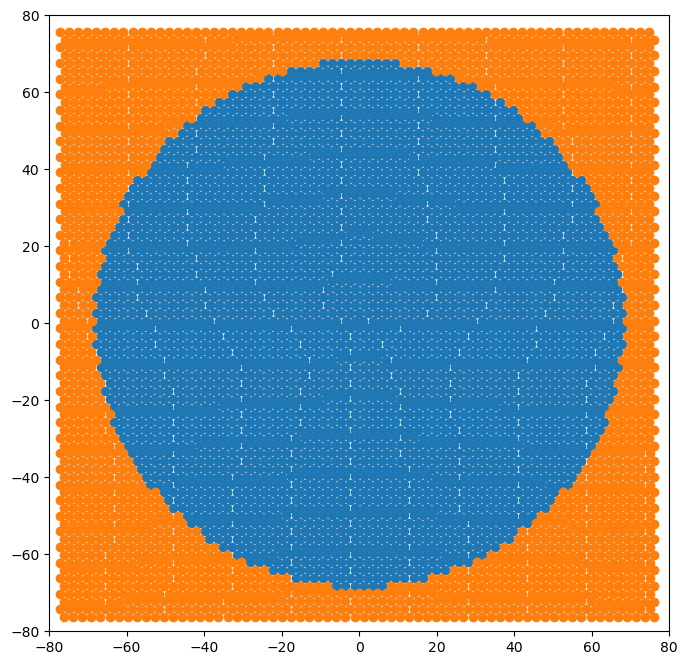

In [22]:
fig = plt.figure(figsize=(8,8))
for atype in disl_system.atypes:
    plt.plot(disl_system.atoms.pos[disl_system.atoms.atype==atype, 1],
             disl_system.atoms.pos[disl_system.atoms.atype==atype, 2], 'o')
plt.xlim(-80, 80)
plt.ylim(-80, 80)
plt.show()

### 4.4. Core structure observations

The core structure of the screw dislocation can be better observed with either the differential displacement map or the Nye tensor map.  Here, we'll demonstrate the differential displacement.  

__NOTE__: The differential displacement calculation requires proper mapping of the atoms between the base and dislocation systems, and between atoms in the systems with their identified neighbors.  If the configuration is very "thin" along the periodic line direction, then some additional considerations are needed to properly compute the differential displacements 

- The neighbor list method used by atomman only builds a list of unique neighbors for each atom. For systems with small periodic box vectors it is possible that neighbors of an atom can include periodic replicas of itself, or multiple replicas of another atom.  These are excluded from the atomman list as they are not unique neighbor pairs.
- The last point can be fixed by replicating the atomic configuration along the periodic direction before analyzing.
- *However*, the differential displacement algorithm needs the atom ids of the base and dislocation systems to directly correspond.  To achieve this, the atomic positions of the dislocation system should remain unwrapped with respect to the base system until the supersize replication is performed.
- If there is no way to retain the unwrapped coordinates during relaxing, you can try to work them out using atomman's displacement calculation.  Computing the displacement between the base and dislocation systems will give the shortest periodic distance between the same atoms in the two configurations.  Then, you can generate an unwapped dislocation system by adding the displacements to the base system's atomic positions.  

__WARNING__: No atomic relaxation has been performed here! Depending on the potential used, the predicted core structure may appear differently!


In [23]:
alat = bcc_disl.ucell.box.a
burgers = bcc_disl.dislsol.burgers

# Supersize the systems along the line direction
big_base_system = base_system.supersize(3, 1, 1)
big_disl_system = disl_system.supersize(3, 1, 1)

# Identify neighbors and compute dd
neighbors = big_disl_system.neighborlist(cutoff = 0.9*alat)
dd = am.defect.DifferentialDisplacement(big_base_system, big_disl_system, neighbors=neighbors, reference=1)

In [24]:
ddmax = np.linalg.norm(burgers) / 2  

# Set dict of keyword parameter values (just to make settings same for all plots below)
params = {}
params['plotxaxis'] = 'y'
params['plotyaxis'] = 'z'
params['xlim'] = (-15, 15)
params['ylim'] = (-15, 15)
params['zlim'] = (alat*3**0.5 / 2 - 0.01, 2 * alat*3**0.5 / 2 + 0.01) # Should be one periodic width (plus a small cushion)
params['figsize'] = 10         # Only one value as the other is chosen to make plots "regular"
params['arrowwidth'] = 1/75    # Made bigger to make arrows easier to see
params['arrowscale'] = 2.5     # Typically chosen to make arrows of length ddmax touch the corresponding atom circles

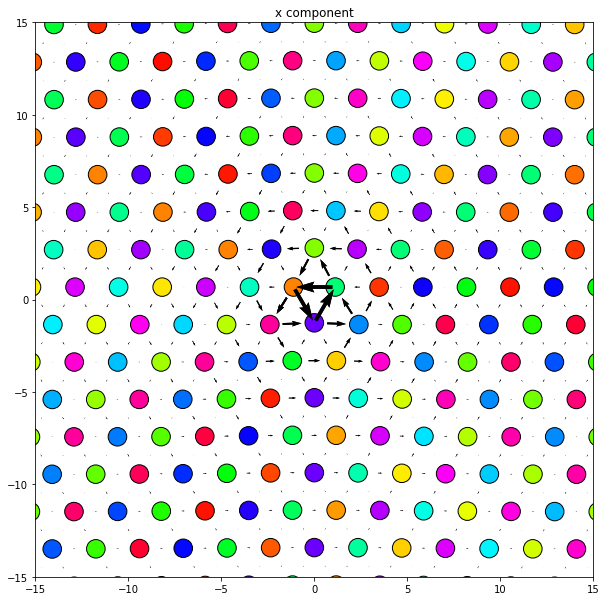

In [25]:
dd.plot('x', ddmax, **params)
plt.title('x component')
plt.show()

## 5. Periodic Array of Dislocations Configuration<a id='section5'></a>

A periodic array of dislocations configuration is one in which the existing system contains a single dislocation and is periodic both in the line direction and the direction of dislocation motion.  Due to the periodicity, the resulting configuration represents an infinite array of equally spaced straight dislocations of the same Burgers positioned on the same slip plane.  These configurations are often used to study planar dislocations with wide cores, and can be used to observe slip behavior and to measure the Peierls barrier. 

### 5.1. Boundary conditions

The dislocation array configuration generated by the Dislocation class has the following boundary conditions

- The two box directions in the slip plane are made periodic while the out-of-plane box direction is non-periodic.
- The system's box vectors and the number of atoms within are adjusted to ensure atomic coherency across the periodic boundary associated with the dislocation motion direction.
- A boundary region is identified at the non-periodic surface.  The atoms in the boundary region are identified by changing their atype values, and are given coordinates that correspond to global linear displacements rather than the local dislocation displacements.

#### 5.1.1. Atomic coherency

The need to adjust the system for coherency across the periodic boundary is due to the nature of the dislocation displacement solution. Within the slip plane, the displacement solution on one side of the dislocation is discontinuous with the above and below limits differing by $\vec{b}$.  On the opposite side of the dislocation, the displacement solution along the slip plane will be halfway between those two limits.  Because of this, the atoms at the two opposite boundaries along the motion direction will be displaced by $± \frac{\vec{b}}{2}$ from each other.  $\vec{b}$ is typically an irreducible crystal vector meaning that $\frac{\vec{b}}{2}$ is usually not and the atoms at the two boundaries do not result in a coherent crystal.

This difference in displacements can be corrected for by either adding or subtracting $\frac{\vec{b}}{2}$ from the box vector most aligned with the dislocation motion direction.  For pure screw dislocations, the sign of the adjustment does not matter and results in a tilt being added to the box vector.  Note that this tilt only changes the periodic vector and does not introduce a shear to the system.

For pure edge dislocations, the sign of the adjustment does matter as the Burgers vector is aligned with the motion direction.  This means that the length of the box vector will either be increased or decreased by the adjustment.  Furthermore, atomic coherency of this adjustment also requires that a half-plane of atoms either be inserted or removed from the system.  Removal of atoms is easier for atomic systems, so the adjustment is always taken such that it results in the box vector shrinking.  Identifying the half-plane of atoms to remove is non-trivial due to the non-linear nature of the dislocation solution displacements.  The method used by the configuration generator is to first adjust the box boundaries, then identify pairs of atoms near the boundaries that have relative position vectors smaller than some small cutoff after taking the periodic boundary into consideration.  One atom of each pair is then deleted.  Validity of the half-plane removal can be checked by comparing the number of atoms deleted to the number of atoms in the bulk crystal within the volume of the cell that was removed.

For mixed dislocations, the adjustments can be seen as a combination of the pure screw and pure edge case.  The algorithm that works for all dislocation characters is to adjust the motion box vector by $-\left|\frac{\vec{b}}{2}\right |$, search for overlapping pairs of atoms at the boundaries and delete one of each pair, then check the number of deleted atoms against the expected number based on the volume change.

#### 5.1.2. Linear gradient displacement

The non-periodic boundary of the dislocation array configuration is an interesting case.  If the positions of the boundary atoms are not fixed, then it creates two free surfaces that can interact with the dislocations.  Alternatively, if the atoms are fixed then you will have some elastic incompatibility at the boundaries that can interact with the dislocation.  Fixing the atoms according to the dislocation solution is not favorable as it is based on having a compact dislocation at a certain position in the system.  This causes issue for slip calculations as the interaction between the dislocation and the boundary region will vary based on the dislocation's position.

One alternative to this is to use a different displacement solution for the boundary region based on applying a linear gradient of displacements to all boundary atoms

$$u_j = \frac{b_j}{2} - \text{sign}(x_2)\left[ \frac{x_1 b_j}{2l} + \frac{b_j}{4}\right],$$

where $l$ is the full periodic length of the system in the $\hat{m}$ direction.  The sign switch indicates that the displacements in the two boundary regions are equal but opposite for a given $x$ coordinate, i.e. the position along the motion direction.  At the two $x$ boundaries, the linear gradient displacements match the dislocation solution displacements on the slip plane.

Using the linear gradient of displacements for the boundary regions does not eliminate the misfit forces at the interface between the boundary region, and therefore there will still be interactions between the boundary region and the dislocation.  However, that interaction will be independent of the dislocation's position.  The slip behavior of dislocations can therefore be studied by applying shear strains/stresses to the system by adding displacements/forces to the boundary atoms. Some examples:

- Quasistatic calculations in which energy/force relaxations are used after incremental displacements of the boundaries. This can be used to estimate the Peierls barrier, with good estimates requiring very small force relaxation tolerances and very small displacements at each iteration.
- Strain-controlled simulations in which a constant displacement rate is applied to the boundary atoms.  Simulations can either have rigid boundaries, in which the boundary atoms only move in the displacement direction, or free-surface boundaries, in which motion in the displacement direction is fixed but MD motions in perpendicular directions are allowed.
- Stress-controlled simulations in which a constant force is applied to the boundary atoms.  Simulations can either have rigid boundaries, in which the boundary is treated as a rigid block that the force acts on, or free-surface boundaries, in which the boundary atoms are subjected to MD steps but each has an extra constant force applied to it.

__Note__ that for some dislocation types it may be preferable to generate the dislocation in the periodic array of dislocations configuration by using only the linear gradient displacement rather than a Volterra dislocation solution.  If only the linear gradient displacement is used, it results in a system in which the disregistry along the slip plane will be linear and vary from 0 to $b$.  For dislocations that split into partials with a wide stacking fault, this solution may actually be closer to the final relaxed configuration than the compact dislocation core given by the Volterra solution.  Furthermore, for screw dislocations that split into partials, practical experience shows that if you start with the Volterra solution that the dislocation often splits along a different slip plane than the intended one in the center of the system.  Using only the linear gradient displacements ensures that the partials are split along the correct slip plane.  

### 5.2. The periodicarray() method

The Dislocation class' periodicarray method generates a periodic array of dislocations configuration based on the dislocation definition given when the object was initialized and the size, shift, boundary condition and method option parameters listed below. 

System size parameters

- __sizemults__ (*tuple, optional*) The size multipliers to use when generating the system.  Values are limited to being positive integers.  The multipliers for the two non-periodic directions must be even.  If not given, the default multipliers will be 2 for the non-periodic directions and 1 for the periodic direction.
- __amin__ (*float, optional*) A minimum thickness to use for the a box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both amin and sizemults is given, then the larger multiplier for the two will be used.
- __bmin__ (*float, optional*) A minimum thickness to use for the b box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both bmin and sizemults is given, then the larger multiplier for the two will be used.
- __cmin__ (*float, optional*) A minimum thickness to use for the c box vector direction of the final system.  Default value is 0.0.  For the non-periodic directions, the resulting vector multiplier will be even.  If both cmin and sizemults is given, then the larger multiplier for the two will be used.

Shift parameters

- __shift__ (*float, optional*) A rigid body shift to apply to the rotated cell prior to inserting the dislocation.  Should be selected such that the ideal slip plane does not correspond to any atomic planes.  Is taken as absolute if shiftscale is False, or relative to the rotated cell's box vectors if shiftscale is True.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given then shiftindex = 0 is used.
- __shiftindex__ (*float, optional*) The index of the identified optimum shifts based on the rotated cell to use.  Different values allow for the selection of different atomic planes neighboring the slip plane.  Note that shiftindex values only apply shifts normal to the slip plane; best shifts for non-planar dislocations (like bcc screw) may also need a shift in the slip plane.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given then shiftindex = 0 is used.
- __shiftscale__ (*bool, optional*) If False (default), a given shift value will be taken as absolute Cartesian.  If True, a given shift will be taken relative to the rotated cell's box vectors.

Center parameters

__center__ (*array-like object or None, optional*) Indicates where the dislocation is positioned in the system relative to the default position at (0, 0) along the box vectors associated with the dislocation solution's m- and n-axes.
__centerscale__ (*bool, optional*) If False (default), a given center value will be taken as absolute Cartesian.  If True, a given center will be taken relative to the rotated cell's box vectors.

Boundary parameters

- __boundarywidth__ (*float, optional*) The width of the boundary region to apply.  Default value is 0.0, i.e. no boundary region.  All atoms in the boundary region will have their atype values changed and will be displaced by linear displacements.
- __boundaryscale__ (*bool, optional*) If False (Default), the boundarywidth will be taken as absolute. If True, the boundarywidth will be taken relative to the magnitude of the unit cell's a box vector.

Method options

- __linear__ (*bool, optional*) If True, then only linear displacements will be used and not the dislocation solution.  Using only linear displacements is useful for screw dislocations and dislocations with large stacking fault distances.  If False (default) then the dislocation solution will be used for the middle displacements and linear displacements only in the boundary region.
- __cutoff__ (*float, optional*) Cutoff distance to use for identifying duplicate atoms to remove. For dislocations with an edge component, applying the displacements creates an extra half-plane of atoms that will have (nearly) identical positions with other atoms after altering the boundary conditions.  Default value is 0.5 Angstrom.

Return options

- __return_base_system__ (*bool, optional*) If True then the dislocation-free base system corresponding to the dislocation system will also be returned.  The base system is used as a reference state for most of the dislocation analysis tools.

### 5.3. Small atomic system example, easy to see atomic positions

In [26]:
base_system, disl_system = fcc_disl.periodicarray(bmin=30, cmin=30,
                                                  boundarywidth=3, boundaryscale=True,
                                                  return_base_system=True)

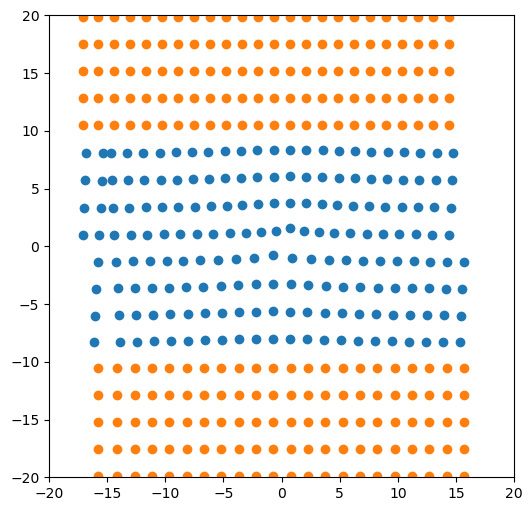

In [27]:
fig = plt.figure(figsize=(6,6))
for atype in disl_system.atypes:
    plt.plot(disl_system.atoms.pos[disl_system.atoms.atype==atype, 1],
             disl_system.atoms.pos[disl_system.atoms.atype==atype, 2], 'o')
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.show()

### 5.4. Large atomic system example, more useful for simulations

In [28]:
base_system, disl_system = fcc_disl.periodicarray(bmin=300, cmin=300,
                                                  boundarywidth=3, boundaryscale=True,
                                                  return_base_system=True)

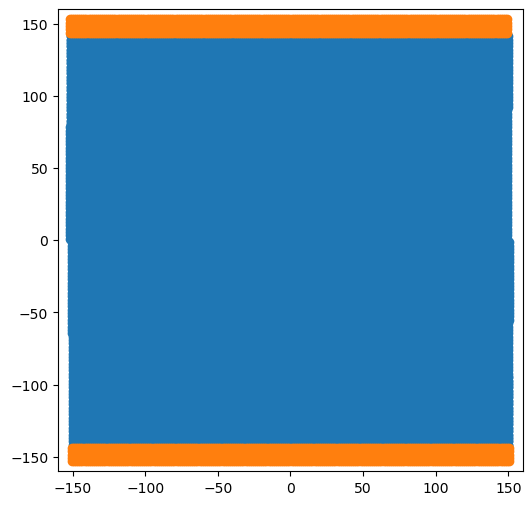

In [29]:
fig = plt.figure(figsize=(6,6))
for atype in disl_system.atypes:
    plt.plot(disl_system.atoms.pos[disl_system.atoms.atype==atype, 1],
             disl_system.atoms.pos[disl_system.atoms.atype==atype, 2], 'o')
plt.xlim(-160, 160)
plt.ylim(-160, 160)
plt.show()

For periodic arrays of dislocations, plotting the disregistry gives a good indication of the dislocation's position and if it has split into partials.

__WARNING__: No atomic relaxation has been performed here! Depending on the potential used, the predicted core structure may appear differently!

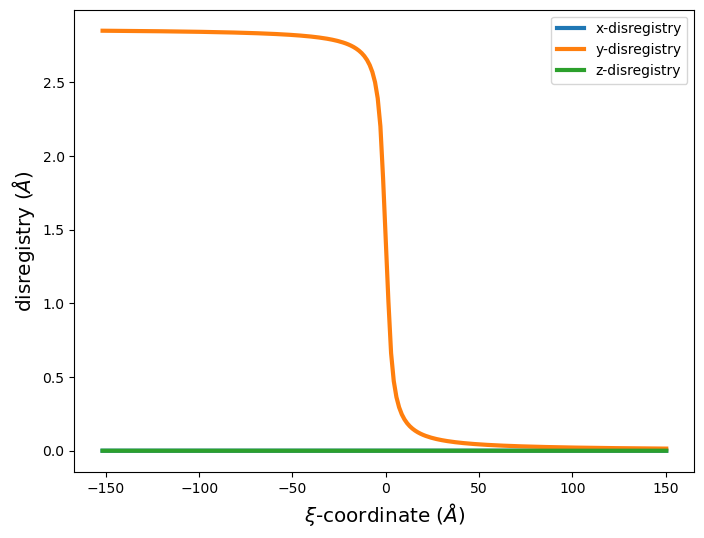

In [30]:
# Plot disregistry
xi, disreg = am.defect.disregistry(base_system, disl_system, m=[0,1,0], n=[0,0,1])

fig = plt.figure(figsize=(8,6))

plt.plot(xi, disreg[:, 0], label='x-disregistry', linewidth=3)
plt.plot(xi, disreg[:, 1], label='y-disregistry', linewidth=3)
plt.plot(xi, disreg[:, 2], label='z-disregistry', linewidth=3)

plt.xlabel('$\\xi$-coordinate ($\AA$)', size='x-large')
plt.ylabel('disregistry ($\AA$)', size='x-large')
plt.legend(fontsize='xx-large')

plt.legend()
plt.show()

### 5.5. Linear gradient displacements only

Here is a repeat of the two configurations above but using only the linear gradient displacements rather than the Volterra solution.

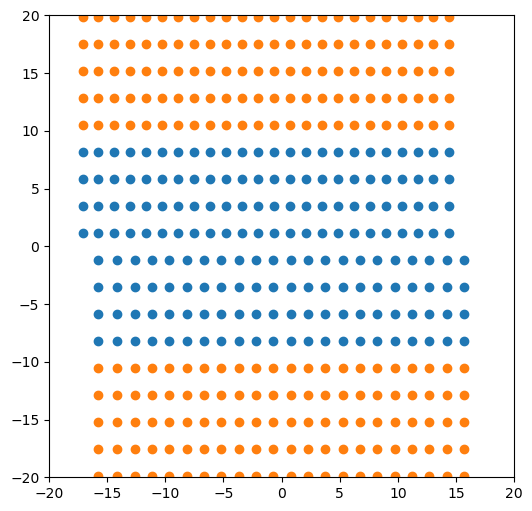

In [31]:
base_system, disl_system = fcc_disl.periodicarray(bmin=30, cmin=30,
                                                  boundarywidth=3, boundaryscale=True,
                                                  linear=True,
                                                  return_base_system=True)

fig = plt.figure(figsize=(6,6))
for atype in disl_system.atypes:
    plt.plot(disl_system.atoms.pos[disl_system.atoms.atype==atype, 1],
             disl_system.atoms.pos[disl_system.atoms.atype==atype, 2], 'o')
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.show()

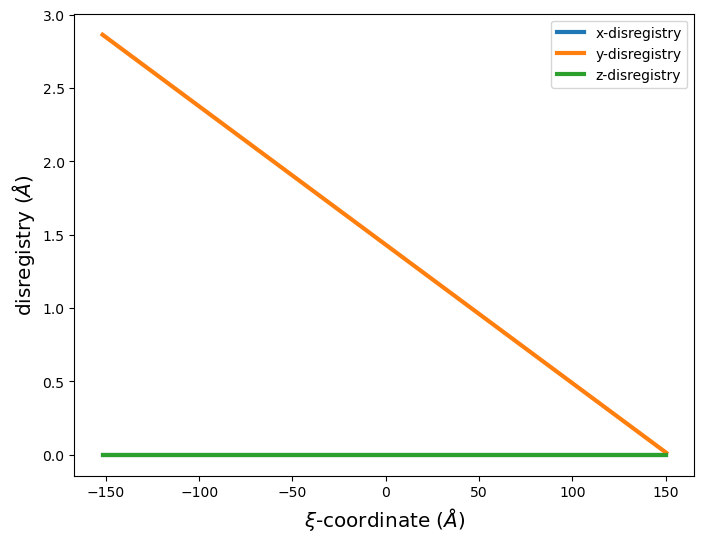

In [32]:
base_system, disl_system = fcc_disl.periodicarray(bmin=300, cmin=300,
                                                  boundarywidth=3, boundaryscale=True,
                                                  linear=True,
                                                  return_base_system=True)

# Plot disregistry
xi, disreg = am.defect.disregistry(base_system, disl_system, m=[0,1,0], n=[0,0,1])

fig = plt.figure(figsize=(8,6))

plt.plot(xi, disreg[:, 0], label='x-disregistry', linewidth=3)
plt.plot(xi, disreg[:, 1], label='y-disregistry', linewidth=3)
plt.plot(xi, disreg[:, 2], label='z-disregistry', linewidth=3)

plt.xlabel('$\\xi$-coordinate ($\AA$)', size='x-large')
plt.ylabel('disregistry ($\AA$)', size='x-large')
plt.legend(fontsize='xx-large')

plt.legend()
plt.show()

## 6. Dislocation dipole configuration<a id='section6'></a>

*Added version 1.4.8*

A dislocation dipole configuration is an atomic system that contains two parallel dislocations of opposite Burgers vectors.  In particular, the configuration method used here corresponds to what is described in [Li et al. Phys Rev B 70, 104113 (2004)](https://doi.org/10.1103/PhysRevB.70.104113).  This configuration has been used for atomistic and DFT investigations of compact dislocation cores as it generates a stable dislocation system with a small number of atoms.

### 6.1. Boundary conditions

The dislocation dipole configuration generated by the Dislocation class has the following boundary conditions

- All three box directions are periodic.  As the system contains two parallel dislocations with opposite Burgers vectors, a Burgers circuit that encompasses both dislocations is zero.  This means that the atoms across the periodic boundaries can be made coherent.  
- With all box directions periodic, the configuration represents a 2D grid of dislocations that are equally spaced in both the $x$ and $y$ directions.  For rows of dislocations along the $x$ direction, the dislocations will have alternating Burgers vectors.
- As for the $y$ columns of dislocations, two settings are possible.  Without modification, all dislocations within a $y$ column will have the same Burgers vector sign.  Alternatively, a tilt of half of the motion direction box vector can be added to the out of plane box vector.  This results in the dipole configuration being a reduced cell of a "quadripole" configuration in which each $y$ column will contain dislocations of alternating Burgers vectors.
- A strain is added to the system that balances the strain due to the work of inserting the dislocation dipole, thus making the configuration stable even at small sizes.

### 6.1.1. 2D dislocation grid and box vectors

While the configuration is typically referred to as a "dipole" configuration as it contains two dislocations, it in fact represents a periodic "quadripole" arrangement of dislocations.  Within the Cartesian system given by dislocation solution axes $[m, n, \xi]$, the quadripole arrangement can be viewed as a 2D rectangular cell when projected along $\xi$.  If the projected 2D cell has dimensions $l$ and $h$, then the full 3D cell for the configuration has the following box vectors

- $\vec{a}_{quad} = [l, 0, \xi_a]$
- $\vec{b}_{quad} = [0, h, \xi_b]$
- $\vec{c}_{quad} = [0, 0, \xi_c]$

where the $\xi_a$, $\xi_b$, and $\xi_c$ terms are the components of the three box vectors along the line direction.  As Volterra dislocation solutions are invariant along $\xi$, the $\xi_a$, $\xi_b$, and $\xi_c$ terms do not affect the dislocation problem and are instead selected solely for crystal compatibility across periodic boundaries. Thus, for any crystal system, one can think of the dislocation system purely from the 2D cell perspective with coordinates along the $m$- and $n$-axes.

The quadripole arrangement of dislocations is constructed by inserting four dislocations into the system such that they form a regular grid of dislocations with alternating Burgers vectors signs.  One way to do this is to insert two dislocations with Burgers vector $\vec{b}$ at positions $[\frac{l}{4}, \frac{h}{4}]$ and $[\frac{3l}{4}, \frac{3h}{4}]$ and insert two dislocations with Burgers vector $-\vec{b}$ at positions $[\frac{l}{4}, \frac{3h}{4}]$ and $[\frac{3l}{4}, \frac{h}{4}]$. Each dislocation is surrounded by dislocations of opposite sign at distances of $\pm\frac{l}{2}$ along the $m$-axis and $\pm\frac{h}{2}$ along the $n$-axis.  Due to this equal spacing, the interaction between any pair of dislocations is cancelled by a dislocation in the opposite direction, thus creating a stable configuration.

Li et al. showed that the rectangular quadripole configuration can be equivalently represented as a dipole configuration using a periodic cell of half the volume by taking advantage of the periodic boundaries.  The 3D box vectors of this smaller dipole cell are

- $\vec{a}_{dipole} = \vec{a}_{quad}$
- $\vec{b}_{dipole} = \frac{1}{2}\left( \vec{b}_{quad} + \vec{a}_{quad} + \vec{b} \right)$
- $\vec{c}_{dipole} = \vec{c}_{quad}$

This results in a 2D cell projection along $\xi$ that is a parallelogram.

The three terms that make up $\vec{b}_{dipole}$ are key to this configuration working.  The $\frac{1}{2}\vec{b}_{quad}$ term results in the height of parallelogram being $\frac{h}{2}$, thus the parallelogram cell area is half of the rectangular cell area.  The $\frac{1}{2}\vec{a}_{quad}$ term defines the tilt of the parallelogram to be $\frac{l}{2}$, which results in all periodic replicas along the $n$-axis being offset by $\frac{l}{2}$.  This periodic offset ensures that the arrangement of dislocations remains a regular grid of alternating Burgers vectors.  The final component, $\frac{1}{2}\vec{b}$, applies a strain to the system to balance the strain due to the work of inserting the dislocation dipole.

### 6.2. Dipole displacement field

The displacement field for the dislocation dipole is constructed by summing Volterra dislocation displacement solutions for individual dislocations.  The process used here follows the work done by [Cai et al. Phil Mag 83, 539 (2003)](https://doi.org/10.1080/0141861021000051109).  The total displacement solution for the periodic dipole configuration consists of three components

1. The displacement solution for a dislocation dipole in an infinite bulk medium.
2. The displacement solution from the dipoles in the periodic images.
3. A correction to ensure that the solution is coherent across the periodic boundaries.

### 6.2.1. Dipole in an infinite medium

The displacement field of a dislocation dipole in an infinite medium can be constructed by adding the displacement fields of the two individual dislocations.  This results in the displacement field necessary to create the dislocations from an otherwise bulk crystal plus an arbitrary rigid body displacement that depends on the particular form of the dislocation solution used.

For the Volterra solutions in atomman, the displacement field of a single dislocation has a radial solution in the mn-plane which results in the displacement field being zero for positions along the $m$-axis in the positive direction, and a discontinuity for positions along the $m$-axis in the negative direction where the limits from above and below are $\frac{\vec{b}}{2}$ and $-\frac{\vec{b}}{2}$, respectively.  For the dipole, one dislocation with with Burgers vector $\vec{b}$ is inserted at a position $m=-\frac{d}{2}, n=0$ and the other dislocation with Burgers vector $-\vec{b}$ is inserted at a position $m=\frac{d}{2}, n=0$.  When the two displacement solutions are added together, the displacements along the $m$-axis for values $m<-\frac{d}{2}$ cancel each other out. This results in the displacement field along the $m$-axis being zero outside the two dislocations, and the discontinuity only existing between the two dislocations.

### 6.2.2. Periodic dipoles

As the final configuration is a periodic array of dipoles, the displacements due to the dislocations in the image cells must also be accounted for.  The displacement in the primary cell due to the dislocations in any arbitrary image cell can be computed using the above dipole solution and shifting the coordinates by the appropriate integer multiples of the two box vectors.  Since the dislocation displacement fields decrease by an order of 1/r, the image cells closest to the primary cell matter the most, so the total displacement field can be approximated by summing the dipole displacements across many of the closest image cells.  These summations are typically done either over a rectangular grid or a spherical area centered around the primary cell.

### 6.2.3. Correction term

The displacement field for the periodic images will always be truncated based on the finite number of image cells included.  The error to correct the displacement can be achieved in one of two ways: evaluate the displacement field computed for different numbers of image cells and extrapolate, or apply a linear correction such that the primary cell is coherent with its nearest images.  The paper by Cai contains in-depth details about the convergence and the error of the periodic dipoles and shows that the two correction methods are equivalent, with the latter being much simpler to compute.

The linear correction term can easily be evaluated by looking at the displacement field produced by the dipoles in the primary cell and a finite number of image cells.  With the cell being periodic, a translation of one integer cell lattice vector should result in a position that is symmetrically equivalent to the original position.  From this, it is easy to deduce that the displacement at the four corners of the 2D cell should be equivalent in order to be coherent across the periodic boundaries.  The linear correction can therefore be obtained from the difference in displacements at three of the corners.


### 6.3. The dipole() method

The Dislocation class' dipole method generates a dislocation dipole configuration based on the dislocation definition given when the object was initialized and the size, shift and method option parameters listed below. 

__NOTE__: The way the system is generated allows for the same shift parameter values to be used for the dipole configuration as the other dislocation generation methods.  For the dipole configuration, the shift is used to align the atomic coordinates with respect to the "left" dislocation in the dipole. If the nature of the dislocation depends on the $x$ coordinate of the core, then care is needed with sizemults to ensure that the "right" dislocation is properly positioned.

System size parameters

- __sizemults__ (*tuple*) The three size multipliers to use when generating the system.  Values should be positive integers if boxtilt is False.  When boxtilt is True, the multipliers are limited to values that result in full lattice vectors once the tilt is added.  Depending on the system, fractional values may be possible, or some integer values not allowed.

Shift parameters

- __shift__ (*array-like object, optional*) A rigid body shift to apply to the rotated cell prior to inserting the dislocation.  Should be selected such that the ideal slip plane does not correspond to any atomic planes.  Is taken as absolute if shiftscale is False, or relative to the rotated cell's box vectors if shiftscale is True.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given will use the shift set during class initialization.
- __shiftindex__ (*float, optional*) The index of the identified optimum shifts based on the rotated cell to use.  Different values allow for the selection of different atomic planes neighboring the slip plane.  Note that shiftindex values only apply shifts normal to the slip plane; best shifts for non-planar dislocations (like bcc screw) may also need a shift in the slip plane.  Cannot be given with shiftindex.  If neither shift nor shiftindex is given then shiftindex = 0 is used then will use the shift set during class initialization.
- __shiftscale__ (*bool, optional*) If False (default), a given shift value will be taken as absolute Cartesian.  If True, a given shift will be taken relative to the rotated cell's box vectors.

Center parameters

__center__ (*array-like object or None, optional*) Indicates where the dislocations are positioned in the configuration  relative to the default locations.  For dipole configurations, th   default locations are at relative positions of (1/4, 1/2) an    (3/4, 1/2) of the box dimensions of the final configuration t     correspond to the dislocation solution's m- and n-axes.
__centerscale__ (*bool, optional*) If False (default), a given center value will be taken as absolute Cartesian.  If True, a given center will be taken relative to the rotated cell's box vectors.
    
Method options

- __boxtilt__ (*bool, optional*) If True (default) then a tilt will be applied to the system such that the resulting periodic configuration will be consistent with a "quadripole" representation in which each dislocation will be surrounded by dislocations of the opposite sign in both the m- and n- directions.  This is achieved by adding half of the box vector most aligned with the m-axis to the box vector most aligned with the n-axis.  A value of False will not tilt the system, so only the sizemults will be applied to the rotated cell. The non-tilted system will have dislocations of the same sign aligned along the n-axis.
- __numreplicas__ (*int, optional*) Indicates how many image cells are used for computing the displacement field of the dipole. A rectangular grid of images is used meaning that there will be NxN total cells evaluated, of which NxN-1 will be image cells.  Default value is 5.
        
Return options

- __return_base_system__ (*bool, optional*) If True then the dislocation-free base system corresponding to the dislocation system will also be returned.  The base system is used as a reference state for most of the dislocation analysis tools.

In [33]:
base_system, disl_system = bcc_disl.dipole(sizemults = [1, 7, 5.5],
                                          boxtilt = True,
                                          return_base_system = True)

print('Number of atoms =', base_system.natoms)

Number of atoms = 231


We can analyze the configuration with both the disregistry and with differential displacements.

__WARNING__: No atomic relaxation has been performed here! Depending on the potential used, the predicted core structure may appear differently!

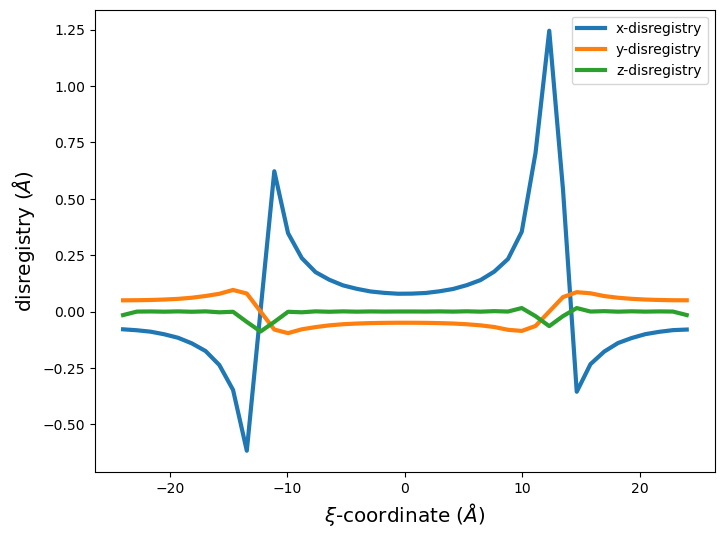

In [34]:
xi, disreg = am.defect.disregistry(base_system, disl_system, m=[0,1,0], n=[0,0,1])

fig = plt.figure(figsize=(8,6))

plt.plot(xi, disreg[:, 0], label='x-disregistry', linewidth=3)
plt.plot(xi, disreg[:, 1], label='y-disregistry', linewidth=3)
plt.plot(xi, disreg[:, 2], label='z-disregistry', linewidth=3)

plt.xlabel('$\\xi$-coordinate ($\AA$)', size='x-large')
plt.ylabel('disregistry ($\AA$)', size='x-large')
plt.legend(fontsize='xx-large')

plt.legend()
plt.show()

In [35]:
# Supersize along the line direction
big_base_system = base_system.supersize(3,1,1)
big_disl_system = disl_system.supersize(3,1,1)

In [36]:
alat = bcc_disl.ucell.box.a
burgers = bcc_disl.dislsol.burgers

# Compute neighbors and dd
neighbors = big_disl_system.neighborlist(cutoff = 0.9*alat)
dd = am.defect.DifferentialDisplacement(big_base_system, big_disl_system, neighbors=neighbors, reference=1)

In [37]:
ddmax = np.linalg.norm(burgers) / 2   # a/2<111> bcc dislocations useb|/2

# Set dict of keyword parameter values (just to make settings same for all plots below)
params = {}
params['plotxaxis'] = 'y'
params['plotyaxis'] = 'z'
params['xlim'] = (-35, 35)
params['ylim'] = (-12, 12)
params['zlim'] = (alat*3**0.5 / 2 - 0.01, 2 * alat*3**0.5 / 2 + 0.01) # Should be one periodic width (plus a small cushion)
params['figsize'] = 20         # Only one value as the other is chosen to make plots "regular"
params['arrowwidth'] = 1/75    # Made bigger to make arrows easier to see
params['arrowscale'] = 2.5    # Typically chosen to make arrows of length ddmax touch the corresponding atom circles

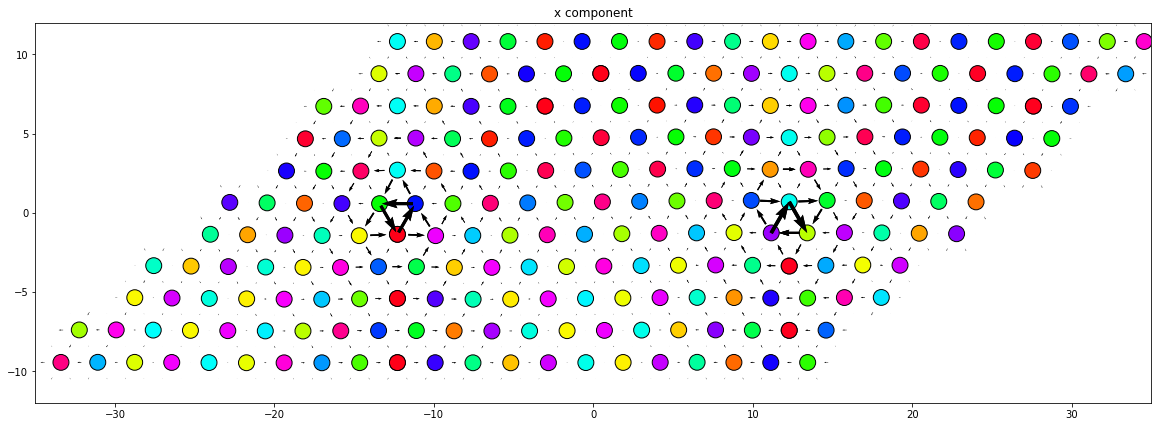

In [38]:
dd.plot('x', ddmax, **params)
plt.title('x component')
plt.show()